## Imports

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import regularizers
import tensorflow as tf
import toolkit
from constants import *
import matplotlib.pyplot as plt
from sklearn import model_selection
import cv2

Using TensorFlow backend.


In [2]:
from keras import backend as K
K.clear_session()
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

## Load DataFrame

In [3]:
df_train = pd.read_hdf("./train_df_128.h5", key="train")
df_loc = pd.read_pickle("./df_loc_128.pkl")
df_seg = pd.read_pickle("./df_seg_128.pkl")

In [4]:
df_train = df_train.merge(df_seg, left_index=True, right_index=True, how='outer', suffixes=('', '_s'))
df_train = df_train.merge(df_loc, left_index=True, right_index=True, how='outer', suffixes=('', '_l'))
df_train = df_train[["patientId","Target",'x','y','width','height',"class","image","seg","loc"]]
df_train.head(10)

,patientId,Target,x,y,width,height,class,image,seg,loc
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,NaN,NaN,NaN,NaN,No Lung Opacity / Not Normal,"[[41, 8, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3...","[[0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0,NaN,NaN,NaN,NaN,No Lung Opacity / Not Normal,"[[6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,00322d4d-1c29-4943-afc9-b6754be640eb,0,NaN,NaN,NaN,NaN,No Lung Opacity / Not Normal,"[[17, 14, 14, 14, 14, 13, 13, 13, 13, 13, 13, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0,NaN,NaN,NaN,NaN,Normal,"[[191, 181, 170, 165, 161, 160, 158, 157, 155,...","[[0.14, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,00436515-870c-4b36-a041-de91049b9ab4,1,264.0,152.0,213.0,379.0,Lung Opacity,"[[3, 3, 3, 2, 2, 3, 5, 5, 6, 7, 8, 9, 9, 10, 1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
5,00436515-870c-4b36-a041-de91049b9ab4,1,562.0,152.0,256.0,453.0,Lung Opacity,"[[3, 3, 3, 2, 2, 3, 5, 5, 6, 7, 8, 9, 9, 10, 1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
6,00569f44-917d-4c86-a842-81832af98c30,0,NaN,NaN,NaN,NaN,No Lung Opacity / Not Normal,"[[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,0,NaN,NaN,NaN,NaN,No Lung Opacity / Not Normal,"[[158, 59, 19, 4, 5, 7, 8, 7, 9, 9, 9, 9, 10, ...","[[0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
8,00704310-78a8-4b38-8475-49f4573b2dbb,1,323.0,577.0,160.0,104.0,Lung Opacity,"[[27, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2...","[[0.07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
9,00704310-78a8-4b38-8475-49f4573b2dbb,1,695.0,575.0,162.0,137.0,Lung Opacity,"[[27, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2...","[[0.07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [5]:
df_train = df_train[(df_train['class'] == 'Lung Opacity') | (df_train['class'] == 'Normal')]
df_train = df_train.reset_index()
df_train.head(10)

,index,patientId,Target,x,y,width,height,class,image,seg,loc
0,3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0,NaN,NaN,NaN,NaN,Normal,"[[191, 181, 170, 165, 161, 160, 158, 157, 155,...","[[0.14, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,4,00436515-870c-4b36-a041-de91049b9ab4,1,264.0,152.0,213.0,379.0,Lung Opacity,"[[3, 3, 3, 2, 2, 3, 5, 5, 6, 7, 8, 9, 9, 10, 1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,5,00436515-870c-4b36-a041-de91049b9ab4,1,562.0,152.0,256.0,453.0,Lung Opacity,"[[3, 3, 3, 2, 2, 3, 5, 5, 6, 7, 8, 9, 9, 10, 1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,8,00704310-78a8-4b38-8475-49f4573b2dbb,1,323.0,577.0,160.0,104.0,Lung Opacity,"[[27, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2...","[[0.07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,9,00704310-78a8-4b38-8475-49f4573b2dbb,1,695.0,575.0,162.0,137.0,Lung Opacity,"[[27, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2...","[[0.07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
5,11,009482dc-3db5-48d4-8580-5c89c4f01334,0,NaN,NaN,NaN,NaN,Normal,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
6,12,009eb222-eabc-4150-8121-d5a6d06b8ebf,0,NaN,NaN,NaN,NaN,Normal,"[[0, 56, 36, 25, 21, 21, 21, 21, 21, 20, 20, 2...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
7,13,00a85be6-6eb0-421d-8acf-ff2dc0007e8a,0,NaN,NaN,NaN,NaN,Normal,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
8,14,00aecb01-a116-45a2-956c-08d2fa55433f,1,288.0,322.0,94.0,135.0,Lung Opacity,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
9,15,00aecb01-a116-45a2-956c-08d2fa55433f,1,547.0,299.0,119.0,165.0,Lung Opacity,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [6]:
df_train_valid = df_train.iloc[13116:]

In [7]:
x_train_seg, x_valid_seg, y_train_seg, y_valid_seg = model_selection.train_test_split(df_train['seg'],df_train['Target'],test_size = 0.25, shuffle=False)

In [8]:
x_train_loc, x_valid_loc, y_train_loc, y_valid_loc = model_selection.train_test_split(df_train['loc'],df_train['Target'],test_size = 0.25, shuffle=False)

In [9]:
x_train_original, x_valid_original, y_train, y_valid = model_selection.train_test_split(df_train['image'],df_train['Target'],test_size = 0.25, shuffle=False)

In [10]:
x_train = np.array([[l * 255, o] for l,o in zip(x_train_loc, x_train_original)])
x_valid = np.array([[l * 255, o] for l,o in zip(x_valid_loc, x_valid_original)])

In [11]:
#x_train = x_train.reshape(-1,128,128,2)
x_train = np.transpose(x_train, [0,2,3,1])
x_valid = np.transpose(x_valid, [0,2,3,1])

In [12]:
y_train = np.array([np.array([1,0]) if y == 0 else np.array([0,1]) for y in y_train])
y_valid = np.array([np.array([1,0]) if y == 0 else np.array([0,1]) for y in y_valid])

In [13]:
patientId_to_coord = {}

for i in range(len(df_train)):
    pid = df_train.iloc[i]['patientId']
    if pid in patientId_to_coord:
        patientId_to_coord[pid].append(np.array([df_train.iloc[i]['x'] / 8 , df_train.iloc[i]['y'] / 8, df_train.iloc[i]['width'] / 8, df_train.iloc[i]['height'] /8 ]))
    else:
        patientId_to_coord[pid] = [np.array([df_train.iloc[i]['x'] / 8 , df_train.iloc[i]['y'] / 8, df_train.iloc[i]['width'] / 8, df_train.iloc[i]['height'] /8 ])]


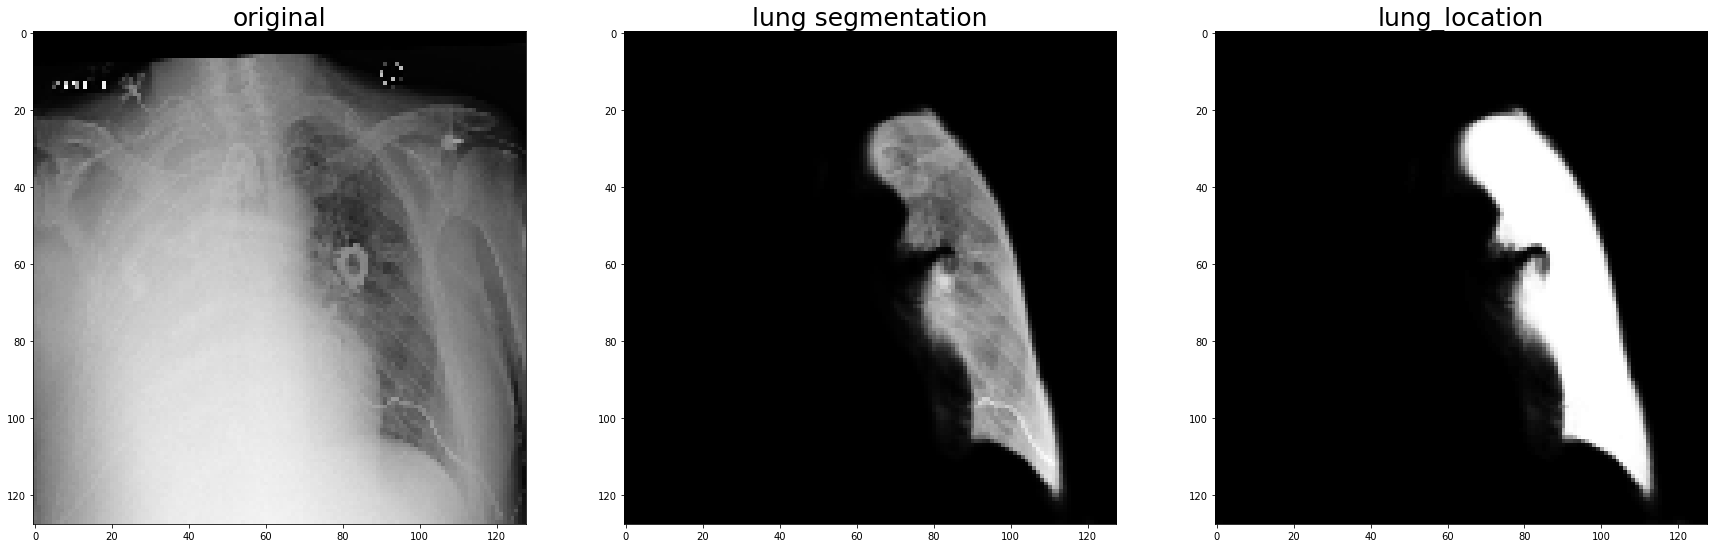

In [14]:
fig, axes = plt.subplots(1,3, figsize=(30,30))
labels = ['original','lung segmentation', 'lung_location']
pics = [x_train_original[9055], x_train_seg[9055],  x_train_loc[9055]]
for i, ax in enumerate(axes):
    #im = overlay_box(pics[i], idx, 255)
    im = pics[i]
    ax.set_title(labels[i], fontsize=25)
    #if i == 1:
    #im = overlay_box(im, 9055, 255)
    ax.imshow(im, cmap='gray')

In [26]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Lambda
from keras.models import Sequential
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense
import keras.backend as K

img_width = 128
img_height = 128
batch_size = 32

print("Building model....")

def global_average_pooling(x):
    return K.mean(x, axis = (1, 2))
    
model = Sequential()

model.add(ZeroPadding2D((1,1),input_shape=((128,128,2))))

'''
model.add(Convolution2D(64, 4, 4, activation='relu', name='conv1_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(64, 4, 4, activation='relu', name='conv1_2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(ZeroPadding2D((1, 1)))

model.add(Convolution2D(128, 4, 4, activation='relu', name='conv2_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, 4, 4, activation='relu', name='conv2_2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(ZeroPadding2D((1, 1)))

model.add(Convolution2D(256, 8, 8, activation='relu', name='conv3_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 8, 8, activation='relu', name='conv3_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 8, 8, activation='relu', name='conv3_3'))

model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(ZeroPadding2D((1, 1)))

#model.add(Convolution2D(512, 16, 16, activation='relu', name='conv5_1'))
#model.add(ZeroPadding2D((1, 1)))
#model.add(Convolution2D(512, 8, 8, activation='relu', name='conv5_2'))
#model.add(ZeroPadding2D((1, 1)))
#model.add(Convolution2D(512, 8, 8, activation='relu', name='conv5_3'))

'''
model.add(ZeroPadding2D((1,1),input_shape=((128,128,2))))


model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(ZeroPadding2D((1, 1)))

model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(ZeroPadding2D((1, 1)))

model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))

model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(ZeroPadding2D((1, 1)))

model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))

model.add(Lambda(global_average_pooling, output_shape=((512,))))

#model.add(MaxPooling2D(pool_size=(3, 3)))
#model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(2, kernel_initializer='glorot_normal', activation='softmax'))

model.compile(loss = "categorical_crossentropy", 
              optimizer = optimizers.Adam(lr=0.00001,beta_1=0.9, beta_2=0.999,decay=0.00001, amsgrad=True), 
              metrics=["categorical_accuracy"])

history = model.fit(x=x_train, y=y_train, validation_data=(x_valid, y_valid), batch_size=batch_size, epochs=20)

#history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=128), \
#                         validation_data=datagen_valid.flow(x_valid, y_valid, 1000),\
#                         #steps_per_epoch = 100,
#                         epochs=300, use_multiprocessing=True, workers=32) #steps_per_epoch = 100
#keras.backend.get_session().run(tf.global_variables_initializer())

Building model....


/jet/var/python/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="conv1_1")`
/jet/var/python/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="conv1_2")`
/jet/var/python/lib/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="conv2_1")`
/jet/var/python/lib/python3.6/site-packages/ipykernel_launcher.py:64: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="conv2_2")`
/jet/var/python/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu", name="conv3_1")`
/jet/var/python/lib/python3.6/site-packages/ipykernel_launcher.py:70: Us

Train on 13116 samples, validate on 4373 samples
Epoch 1/20
13116/13116 [==============================] - 45s 3ms/step - loss: 0.4324 - categorical_accuracy: 0.7940 - val_loss: 0.2752 - val_categorical_accuracy: 0.8962
Epoch 2/20
13116/13116 [==============================] - 43s 3ms/step - loss: 0.3026 - categorical_accuracy: 0.8753 - val_loss: 0.2673 - val_categorical_accuracy: 0.9030
Epoch 3/20
13116/13116 [==============================] - 43s 3ms/step - loss: 0.2734 - categorical_accuracy: 0.8869 - val_loss: 0.2191 - val_categorical_accuracy: 0.9213
Epoch 4/20
13116/13116 [==============================] - 43s 3ms/step - loss: 0.2626 - categorical_accuracy: 0.8938 - val_loss: 0.2550 - val_categorical_accuracy: 0.9094
Epoch 5/20
13116/13116 [==============================] - 43s 3ms/step - loss: 0.2521 - categorical_accuracy: 0.8981 - val_loss: 0.2081 - val_categorical_accuracy: 0.9243
Epoch 6/20
13116/13116 [==============================] - 43s 3ms/step - loss: 0.2395 - categori

In [15]:
model.save_weights("original_custom_vgg_binary.h5")

In [17]:
alpha_00001 = history.history["categorical_accuracy"]

In [19]:
alpha_0000001 = history.history["categorical_accuracy"]

In [21]:
alpha_001 = history.history["categorical_accuracy"]

In [24]:
history.history.keys()

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy'])

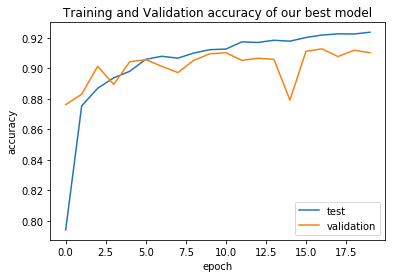

In [32]:
plt.plot(history.history["categorical_accuracy"])
plt.plot(np.array(history.history['val_categorical_accuracy']))

plt.title('Training and Validation accuracy of our best model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['test', 'validation'], loc='lower right')
plt.show()

In [94]:
from sklearn.metrics import confusion_matrix
pred = model.predict(x_valid)
confusion_matrix([np.argmax(y) for y in y_valid], [np.argmax(p) for p in pred])

array([[2261,  179],
       [ 178, 1755]])

In [92]:
confusion_matrix([np.argmax(y) for y in y_valid], [np.argmax(p) for p in pred])

array([[2440,    0],
       [1933,    0]])

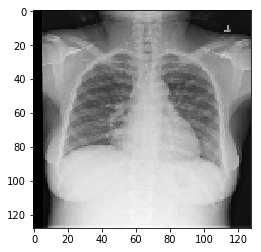

In [116]:
plt.imshow(x_valid[10,:,:,1], cmap='gray')

In [108]:
wrong

(array([   7,    8,   10,   19,   21,   22,   25,   26,   40,   61,   62,
          70,   87,   88,   89,  103,  104,  110,  111,  194,  206,  207,
         208,  255,  256,  289,  308,  309,  319,  360,  361,  362,  368,
         373,  374,  375,  376,  378,  382,  393,  402,  407,  408,  417,
         425,  426,  433,  434,  435,  438,  439,  477,  573,  575,  578,
         591,  600,  603,  610,  618,  629,  637,  649,  678,  679,  690,
         691,  714,  715,  734,  736,  742,  766,  767,  769,  770,  808,
         877,  942,  955, 1137, 1138, 1166, 1324, 1380, 1392, 1433, 1532,
        1657, 1710, 1727, 1736, 1743, 1767, 1770, 1778, 1796, 1833, 1859,
        1860, 1861, 1862, 1968, 2044, 2047, 2071, 2093, 2101, 2171, 2216,
        2261, 2359, 2386, 2394, 2419, 2434, 2468, 2487, 2504, 2510, 2522,
        2558, 2566, 2587, 2594, 2619, 2658, 2686, 2776, 2809, 2810, 2811,
        2819, 2860, 2876, 2891, 2892, 2893, 2913, 2922, 3022, 3029, 3084,
        3174, 3208, 3209, 3244, 3271, 

## CAM

In [119]:
class Graph: 
  
    def __init__(self, g): 
        plt.imshow(g)
        self.ROW = g.shape[0]
        self.COL = g.shape[1] 
        self.graph = g
        self.classes = np.zeros_like(g)
        self.visited = np.zeros_like(g)
        self.visited[g == 0] = 1
  
    def isSafe(self, i, j): 

        return (i >= 0 and i < self.ROW and 
                j >= 0 and j < self.COL and 
                not self.visited[i][j] and self.graph[i][j] > 0) 
              
  
    def DFS(self, i, j, class_label):   
        rowNbr = [-1, -1, -1,  0, 0,  1, 1, 1] 
        colNbr = [-1,  0,  1, -1, 1, -1, 0, 1] 
          
        self.visited[i][j] = 1
        self.classes[i][j] = class_label + 1

        for k in range(8): 
            if self.isSafe(i + rowNbr[k], j + colNbr[k]): 
                self.DFS(i + rowNbr[k], j + colNbr[k], class_label) 
  
  
    def countIslands(self): 
        count = 0

        while 0 in self.visited:
            x_coord, y_coord = np.where(self.visited == 0)
            idx = np.random.randint(len(x_coord))
            x,y = x_coord[idx], y_coord[idx]

            if self.visited[x][y] == 0 and self.graph[x][y] > 0: 
                self.DFS(x, y, count) 
                count += 1
  
        return self.classes, count

In [120]:
def calculate_iou(pairs):

    results = []
    
    for p in pairs:
        y_true = p[0]
        y_pred = p[1]
        y_true = y_true.astype(np.float32)
        y_pred = y_pred.astype(np.float32)
        x_boxTrue_tleft = y_true[0] 
        y_boxTrue_tleft = y_true[1]
        boxTrue_width = y_true[2]
        boxTrue_height = y_true[3]
        area_boxTrue = (boxTrue_width * boxTrue_height)

        x_boxPred_tleft = y_pred[0]
        y_boxPred_tleft = y_pred[1]
        boxPred_width = y_pred[2]
        boxPred_height = y_pred[3]
        area_boxPred = (boxPred_width * boxPred_height)

        x_boxTrue_br = x_boxTrue_tleft + boxTrue_width
        y_boxTrue_br = y_boxTrue_tleft + boxTrue_height
        x_boxPred_br = x_boxPred_tleft + boxPred_width
        y_boxPred_br = y_boxPred_tleft + boxPred_height 

        x_boxInt_tleft = np.max([x_boxTrue_tleft,x_boxPred_tleft])
        y_boxInt_tleft = np.max([y_boxTrue_tleft,y_boxPred_tleft]) 
        
        x_boxInt_br = np.min([x_boxTrue_br,x_boxPred_br])
        y_boxInt_br = np.min([y_boxTrue_br,y_boxPred_br]) 

        area_of_intersection = \
        np.max([0,(x_boxInt_br - x_boxInt_tleft)]) * np.max([0,(y_boxInt_br - y_boxInt_tleft)])

        iou = area_of_intersection / ((area_boxTrue + area_boxPred) - area_of_intersection)

        iou = iou.astype(np.float32)
        results.append(iou)
    
    return np.mean(results)
    
idx = 1

y1, x1, height, width = df_train.iloc[idx]['y'], df_train.iloc[idx]['x'], df_train.iloc[idx]['height'], df_train.iloc[idx]['width']
y1 = int(y1/8)
x1 = int(x1/8)
height = int(height/8)
width = int(width/8)
y_true = np.array([x1,y1,width,height, 1])



In [39]:
model_final = model
model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_31 (ZeroPaddi (None, 130, 130, 2)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 128, 128, 64)      1216      
_________________________________________________________________
zero_padding2d_32 (ZeroPaddi (None, 130, 130, 64)      0         
_________________________________________________________________
conv1_2 (Conv2D)             (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
zero_padding2d_33 (ZeroPaddi (None, 66, 66, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 64, 64, 128)       73856     
__________

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


TypeError: 'NoneType' object is not iterable

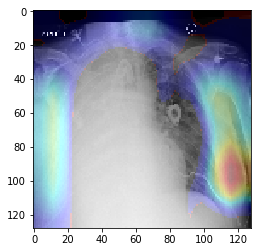

In [177]:
import cv2
import itertools
import matplotlib.pyplot as plt
import pylab
    
def overlay_box(im, idx, df_train, rgb = np.array([225,0,0]), stroke=1):

    y1, x1, height, width = df_train.iloc[idx]['y'], df_train.iloc[idx]['x'], df_train.iloc[idx]['height'], df_train.iloc[idx]['width']
    y1 = int(y1/8)
    x1 = int(x1/8)
    height = int(height/8)
    width = int(width/8)
    
    y2 = y1 + height
    x2 = x1 + width

    print(y1,y2,x1,x2)
    
    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im


def draw_predicted_box(im, x1, x2, y1, y2, rgb = np.array([0,0,255]), stroke=1):
    
    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

def get_output_layer(model, layer_name):
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer = layer_dict[layer_name]
    return layer

def plot_cam_localization(i, idx, model, x_train, x_train_original, df, final_conv_name = "conv5_3"):
   
    height, width = 128, 128 

    img = x_train[i]
    img = np.array([np.transpose(np.float32(img), (0, 1, 2))])
    class_weights = model_final.layers[-1].get_weights()[0]
    final_conv_layer = get_output_layer(model_final, final_conv_name)
    get_output = K.function([model_final.layers[0].input], [final_conv_layer.output, model_final.layers[-1].output])
    [conv_outputs, predictions] = get_output([img])
    
    if np.argmax(predictions) == 0:
        return None

    conv_outputs = conv_outputs[0, :, :, :]

    cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, 0]):
        cam += w * conv_outputs[:, :, i]
        
    cam /= np.max(cam)
    cam = cv2.resize(cam, (height, width))
    heatmap = cv2.applyColorMap(np.uint8(-cam*255), cv2.COLORMAP_JET)
    heatmap[np.where(cam < 0.0)] = 0


    img = np.repeat(x_train_original[idx][:, :, np.newaxis] , 3, axis=2).astype(int)
    #img = heatmap * 0.3 + img * 0.7
    img = heatmap * 0.3 / 255 + img /255
    plt.imshow(img)

    
    rgb = np.floor(np.random.rand(3) * 256).astype('int')
    im = img
    im = overlay_box(img, idx, df, stroke=1)
    plt.imshow(img)

    heatmap_avg = heatmap.mean(axis=2)

    g = Graph(heatmap_avg) 
    
    class_labels, count = g.countIslands()
    
    y_pred = []
    
    for i in range(1, count+1):
        y_coord, x_coord = np.where(class_labels == i)
        min_x = min(x_coord)
        max_x = max(x_coord)
        min_y = min(y_coord)
        max_y = max(y_coord)
        width = max_x - min_x
        height = max_y - min_y
        
        if width < 12 or height < 12:
            continue
        y_pred.append(np.array([min_x, min_y, width, height]))
        
        im = draw_predicted_box(im, min_x, max_x, min_y, max_y)
    plt.imshow(img)
    return heatmap, img
    pid = df_train.iloc[idx]['patientId']
    y_true = patientId_to_coord[pid]
    
    if np.isnan(y_true[0]).any():
        return 0
    
    if len(y_true) >= len(y_pred):
        possible_alignments = [list(zip(x,y_pred)) for x in itertools.permutations(y_true,len(y_pred))]
    else:
        possible_alignments = [list(zip(y_true, x)) for x in itertools.permutations(y_pred,len(y_true))]

    max_alignment_iou = max([calculate_iou(pa) for pa in possible_alignments])
    return max_alignment_iou
    #plt.imshow(im, cmap=pylab.cm.gist_gray)

    #print(img.shape)
    #cv2.imwrite(output_path, img)
    #plt.imshow(np.uint8(im))
    #return heatmap
    
heatmap, img = plot_cam_localization(9055, 9055, model_final, x_train, x_train_original, df_train, "conv5_3")

TypeError: 'NoneType' object is not iterable

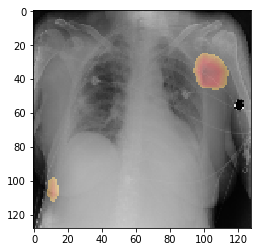

In [167]:
idx = 33
heatmap, img = plot_cam_localization(idx, idx, model_final, x_train, x_train_original, df_train, "conv5_3")

In [21]:
import sys
sys.setrecursionlimit(6000)

In [1]:
iou_total = []

for i, idx in enumerate(range(13116,17490)):
    if i % 40 == 0:
        print(f"{i} / 4374")
    try:
        iou_total.append(plot_cam_localization(i, idx, model_final, x_valid, x_valid_original, df_train_valid, "conv5_3"))
    except:
        print(i)
'''
#idx = 8
#plot_cam_localization(1, 1, model_final, x_train, x_train_original, df_train, "conv5_3")
for i in range(13116,):
    try:
        iou_total.append(plot_cam_localization(i, i, model_final, x_train, x_train_original, df_train, "conv5_3"))
    except:
        print(i)    
'''
#hma = plot_cam_localization(16, 16, model_final, x_train, x_train_original, df_train, "conv5_3")

'\n#idx = 8\n#plot_cam_localization(1, 1, model_final, x_train, x_train_original, df_train, "conv5_3")\nfor i in range(13116,):\n    try:\n        iou_total.append(plot_cam_localization(i, i, model_final, x_train, x_train_original, df_train, "conv5_3"))\n    except:\n        print(i)    \n'

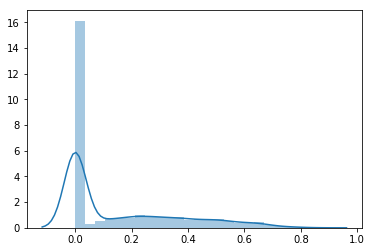

In [37]:
import seaborn as sns
sns.distplot(it)

In [39]:
print(f"IoU max: {it.max()} \n IoU mean: {it.mean()} \n IoU mean without 0s: {it[it != 0].mean()}")

IoU max: 0.8451061844825745 
 IoU mean: 0.1508548204704154 
 IoU mean without 0s: 0.3468866898080236


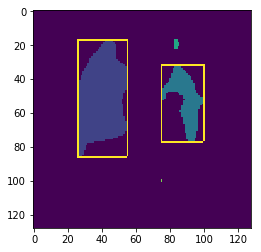

In [162]:
def overlay_box(im, x1, x2, y1, y2, rgb = 5, stroke=1):
    
    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im
g = Graph(heatmap_avg) 
class_labels, count = g.countIslands()

y_pred = []

for i in range(1, count+1):
    y_coord, x_coord = np.where(class_labels == i)
    min_x = min(x_coord)
    max_x = max(x_coord)
    min_y = min(y_coord)
    max_y = max(y_coord)
    width = max_x - min_x
    height = max_y - min_y
    if width > 10 or height > 10: 
        y_pred.append(np.array([min_x, min_y, width, height]))
        overlay_box(class_labels,min_x, max_x, min_y, max_y)
plt.imshow(class_labels)

In [135]:
y_pred

[array([17, 26, 69, 29]), array([32, 75, 45, 25])]

In [657]:
from sklearn.cluster import KMeans
from sklearn import metrics

def k_mean_distance(data, cx, cy, cz, i_centroid, cluster_labels):
    distances = [np.sqrt((x-cx)**2+(y-cy)**2 + (z-cz)**2) for (x, y,z) in data[cluster_labels == i_centroid]]
    return np.mean(distances)



x_coord, y_coord, z_coord = np.where(heatmap > 0 )
features = np.array([[x,y,z] for x,y,z in zip(x_coord, y_coord, z_coord)])
for i in range(2,10):
    kmeans = KMeans(n_clusters=i, random_state=0)
    labels = kmeans.fit_predict(features)
    #centroids = kmeans.cluster_centers_

    #c_mean_distances = []
    #for i, (cx, cy, cz) in enumerate(centroids):
    #    mean_distance = k_mean_distance(features, cx, cy, cz, i, labels)
    #    c_mean_distances.append(mean_distance)
    #print(np.array(c_mean_distances).mean())
    print(f"Score: {metrics.silhouette_score(features, labels, metric='euclidean')} for {i} classes")

Score: 0.5983980710733049 for 2 classes
Score: 0.5423329735606265 for 3 classes
Score: 0.5013245660726321 for 4 classes
Score: 0.41908292244894274 for 5 classes
Score: 0.43611342863561486 for 6 classes
Score: 0.4418089725739655 for 7 classes
Score: 0.44292870570659765 for 8 classes
Score: 0.4201320096250376 for 9 classes


In [543]:
def generate_bbox(cls_map, reg, scale, threshold):
    stride = 2
    # stride = 4
    cellsize = 12
    # cellsize = 25

    # index of class_prob larger than threshold
    t_index = np.where(cls_map > threshold)

    # find nothing
    if t_index[0].size == 0:
        return np.array([])
    # offset
    dx1, dy1, dx2, dy2 = [reg[t_index[0], t_index[1], i] for i in range(4)]

    reg = np.array([dx1, dy1, dx2, dy2])
    score = cls_map[t_index[0], t_index[1]]
    boundingbox = np.vstack([np.round((stride * t_index[1]) / scale),
                             np.round((stride * t_index[0]) / scale),
                             np.round((stride * t_index[1] + cellsize) / scale),
                             np.round((stride * t_index[0] + cellsize) / scale),
                             score,
                             reg])

    return boundingbox.T

reg = np.zeros((128,128,3))
box = generate_bbox(heatmap, reg, 1)

(128, 128, 3)

In [2]:
heatmap

In [ ]:
rgb = np.floor(np.random.rand(3) * 256).astype('int')
im = overlay_box(im=im, idx, rgb=rgb, stroke=6)

plt.imshow(im, cmap=pylab.cm.gist_gray)
    
def overlay_box(im, idx, rgb, stroke=1):
    """
    Method to overlay single box on image

    """
    # --- Convert coordinates to integers
    
    # --- Extract coordinates
    y1, x1, height, width = df_train.iloc[idx]['x'], df_train.iloc[idx]['y'], df_train.iloc[idx]['width'], df_train.iloc[idx]['height']
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

In [4]:
import cv2
def get_output_layer(model, layer_name):
    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer = layer_dict[layer_name]
    return layer

idx = 32

img = x_train[idx]

#Get the 512 input weights to the softmax.
height, width = 128, 128 

img = x_train[2]
img = np.array([np.transpose(np.float32(img), (0, 1, 2))])
class_weights = model_final.layers[-2].get_weights()[0]
final_conv_layer = get_output_layer(model_final, "conv2d_42")
get_output = K.function([model_final.layers[0].input], [final_conv_layer.output, model_final.layers[-1].output])
[conv_outputs, predictions] = get_output([img])

conv_outputs = conv_outputs[0, :, :, :]

Create the class activation map.
cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])
for i, w in enumerate(class_weights[:, 1]):
    cam += w * conv_outputs[:, :, i]
print("predictions", predictions)

cam /= np.max(cam)
cam = cv2.resize(cam, (height, width))
heatmap = cv2.applyColorMap(np.uint8(-cam*255), cv2.COLORMAP_JET)
heatmap[np.where(cam < 0.1)] = 0


img = np.repeat(x_train_original[idx][:, :, np.newaxis] , 3, axis=2)
img = heatmap * 0.3 + np.flip(img, axis=1) * 0.8
print(img.shape)
cv2.imwrite(output_path, img)
plt.imshow(np.uint8(img))

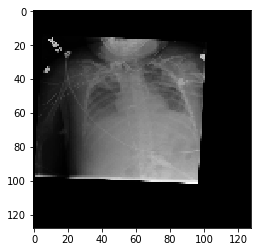

In [17]:
#img = np.repeat(x_train_original[2][:, :, np.newaxis], 3, axis=2)

plt.imshow(x_train_original[8], cmap="gray")